In [1]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [2]:
def barrier_and_grad(x, y, L, epsilon=1e-4):
    def soft_repel(s, Ls):
        return 1 / (s + epsilon) + 1 / (Ls - s + epsilon)
    
    def grad_soft_repel(s, Ls):
        return -1 / (s + epsilon)**2 + 1 / (Ls - s + epsilon)**2

    B = soft_repel(x, L[0]) + soft_repel(y, L[1])
    dBx = grad_soft_repel(x, L[0])
    dBy = grad_soft_repel(y, L[1])
    return B, np.array([dBx, dBy])

In [3]:
def sample_from_pdf_2d(pdf, x_bounds, y_bounds, n_samples):
    samples = []
    xmin, xmax = x_bounds
    ymin, ymax = y_bounds
    
    # Find max of pdf in bounding box (or approximate)
    xs = np.linspace(xmin, xmax, 200)
    ys = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[pdf((x, y)) for x in xs] for y in ys])
    M = Z.max()  # Upper bound
    
    while len(samples) < n_samples:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        u = np.random.uniform(0, M)
        if u < pdf(np.array((x, y))):   # accept
            samples.append([x, y])
    return np.array(samples)

In [4]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
# Discretize the search space into 100-by-100 mesh grids
num_grid = 256
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)

In [5]:
# Configure the index vectors
num_k_per_dim = 32
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T
lamk_list = np.ones(ks.shape[0]) 
hk_list = np.zeros(ks.shape[0])
h = 1 / (num_k_per_dim + 1)
sigmas = np.array([1/8 ,1/2, 1., 2., 8.]) * h
#sigmas = np.array([0.01,0.1, 0.5])
weights = 1 / sigmas**2
#weights = np.ones(len(sigmas))
weights /= np.sum(weights)
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
centers = np.zeros(ks.shape)
for i, k_vec in enumerate(ks):
    center = np.array([1 /(num_k_per_dim + 1) * (k_vec[0] + 1),  1/(num_k_per_dim + 1) * (k_vec[1] + 1)])
    centers[i] = center
    ## Try sum of radials for more stability
    sq_dists = np.sum((grids - center)**2, axis=-1)
    sigmas = np.array(sigmas).reshape(-1, 1)
    weights = np.array(weights).reshape(-1, 1)
    rbfs = np.exp(-sq_dists / (2 * sigmas**2))
    fk_vals = np.sum(weights * rbfs, axis=0)
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik
print(sigmas)

[[0.0038]
 [0.0152]
 [0.0303]
 [0.0606]
 [0.2424]]


In [6]:
# Specify the dynamic system 
import infomeasure as im
divergence = []
dt = 0.01
tsteps = 100001
ud = .2 # desired velocity in m/s
results_fourier = []

def dyn(xt, ut):
    xdot = ut 
    return ut

def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)
    return xt_new 

# start SMC iteration
#xt = np.random.uniform(low=0.2, high=0.8, size=(2,)) # inital state
xt = np.array([0.5,0.5]) # for fair comparison!
x_traj = np.zeros((tsteps, 2)) # trajectory
ck_list_update = np.zeros(ks.shape[0])  # trajectory coefficients (update over time, not normalized)
metric_log = []  # record ergodic metric at each step
timeit = []
Wasserstein = []

for t in range(tsteps):

    B_val, dB = barrier_and_grad(xt[0], xt[1], L_list)
    base_weight = 1e-4 
    distance_to_wall = np.minimum(xt, L_list - xt)
    min_dist = np.min(distance_to_wall)
    barrier_weight = base_weight / (min_dist + 1e-8)

    rbfs = np.exp(-(np.sum((xt - centers)**2, axis = -1))/(2 * (sigmas.reshape(-1, 1))**2))
    fk_xt_all = np.sum(weights.reshape(-1, 1) * rbfs, axis=0)

    ck_list_update += fk_xt_all * dt
    # step 3: compute the derivative of all basis functions at the current state

    ## Radial basis multiple sigmas
    dfk_xt_all = np.zeros(ks.shape)
    for sigma, w in zip(sigmas, weights):
        dfk_xt_all += -w* (sigma**(-2) * (xt - centers) * fk_xt_all[..., np.newaxis])
    dfk_xt_all = dfk_xt_all.T



    # step 4: compute control signal
    bt = np.sum(lamk_list * ((ck_list_update / (t*dt+dt)) - phik_list) * dfk_xt_all, axis=1) + barrier_weight * dB
    ut = -ud * bt / (np.linalg.norm(bt) + 1e-8)

    # print('ut: ', np.linalg.norm(ut))a
    
    # step 5: execute the control, move on to the next iteration
    xt = step(xt, ut)
    x_traj[t] = xt.copy()
    erg_metric = np.sum(np.square(phik_list - ck_list_update / (t*dt+dt)))
    metric_log.append(erg_metric)
    if not t % 10000 and t != 0:#t == 1000 or t == 10000 or t == 100000 or t == 1000000:
        print(f"Step {t}, Position: {xt[:2]}, Metric: {erg_metric:.5f}")  
        mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples = x_traj[:t,:].shape[0])
        KL = im.kld(x_traj[:t,:],mu_samples[:t,:], approach='metric')
        divergence.append(KL)
        print(KL, 'emp')


Step 10000, Position: [0.7075 0.2233], Metric: 0.00003
1.393311971031297 emp
Step 20000, Position: [0.2465 0.1694], Metric: 0.00001
0.9524919016906606 emp
Step 30000, Position: [0.3116 0.3317], Metric: 0.00000
0.7475283304309963 emp
Step 40000, Position: [0.177  0.4346], Metric: 0.00000
0.6112922518932711 emp
Step 50000, Position: [0.6807 0.3103], Metric: 0.00000
0.5064745311917516 emp
Step 60000, Position: [0.6528 0.2073], Metric: 0.00000
0.4492692781160783 emp
Step 70000, Position: [0.3512 0.4615], Metric: 0.00000
0.4101261447047244 emp
Step 80000, Position: [0.5143 0.6778], Metric: 0.00000
0.38900833472608176 emp
Step 90000, Position: [0.2455 0.2563], Metric: 0.00000
0.36028041401105293 emp
Step 100000, Position: [0.5334 0.5215], Metric: 0.00000
0.32902429147657375 emp


Step 100000, Position: [0.3605 0.3254], Metric: 0.00003
0.28788946658883874 emp This is for np.array([0.01,0.1, .5])

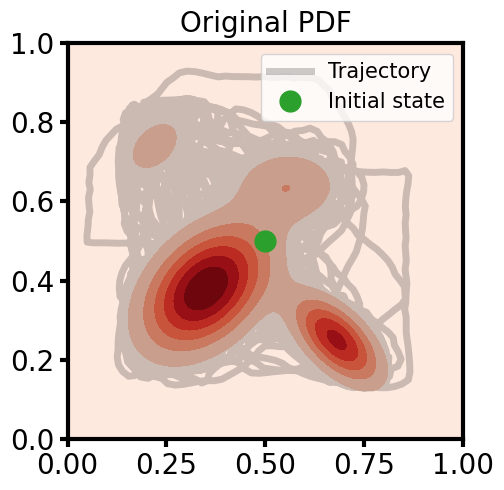

In [7]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
#ax.set_xlim(0.0, L_list[0])
#ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)
plt.show()
plt.close()

2025-08-21 14:02:31,730 |  WARNING | legend.py:1323 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


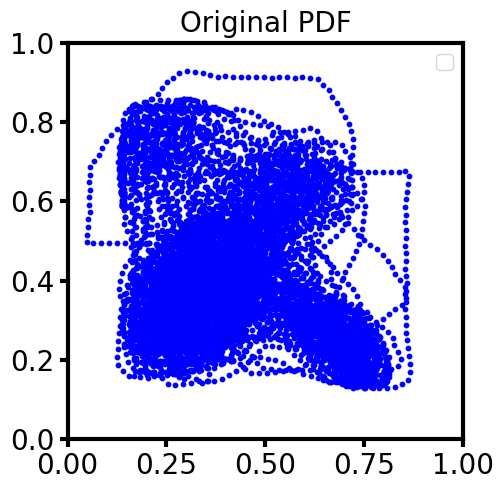

In [8]:
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(x_traj[::10, 0], x_traj[::10, 1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

In [9]:
mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples = x_traj[:t,:].shape[0])


In [10]:
KL = im.kld(x_traj[:t,:],mu_samples, approach='metric')
print(KL, 'emp')

0.3279785637273145 emp


In [11]:
divergence

[1.393311971031297,
 0.9524919016906606,
 0.7475283304309963,
 0.6112922518932711,
 0.5064745311917516,
 0.4492692781160783,
 0.4101261447047244,
 0.38900833472608176,
 0.36028041401105293,
 0.32902429147657375]

In [13]:
np.save(rf"C:/Users/JP/Documents/TU Berlin/Ergodicity_clean/Experiments/Divergence_data/Radial_{num_k_per_dim}.npy", np.array(divergence))